In [ ]:
#author: SYJ
######
# Packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import t

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys

sys.path.append('/content/drive/MyDrive/Colab Notebooks')
ab_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AB testing/ab_data.csv")
ab_test.head()

Mounted at /content/drive


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [ ]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [ ]:
#Data cleaning

dup_rows = ab_test[ab_test.duplicated()]
display(dup_rows)

cleaned_df = ab_test[~((ab_test['group'] == 'control') & (ab_test['landing_page'] == 'new_page'))
& ~((ab_test['group'] =='treatment')& (ab_test['landing_page'] == 'old_page'))]

cont_df = cleaned_df[cleaned_df['group'] == 'control']
treat_df = cleaned_df[cleaned_df['group'] == 'treatment']

print(cont_df.shape)
print(treat_df.shape)

,user_id,timestamp,group,landing_page,converted


(145274, 5)
(145311, 5)


In [ ]:
print(f"control group: {cont_df.converted.value_counts()}")
print(f"experiment group: {treat_df.converted.value_counts()}")

control group: converted
0    127785
1     17489
Name: count, dtype: int64
experiment group: converted
0    128047
1     17264
Name: count, dtype: int64


In [ ]:
#conversion rates

conv_cont =len(cont_df[cont_df.converted ==1])/len(cont_df)
conv_treat = len(treat_df[treat_df.converted ==1])/len(treat_df)

print(f"conversion rate control group: {conv_cont:.3f}")
print(f"conversion rate experiment group: {conv_treat:.3f}")

conversion rate control group: 0.120
conversion rate experiment group: 0.119


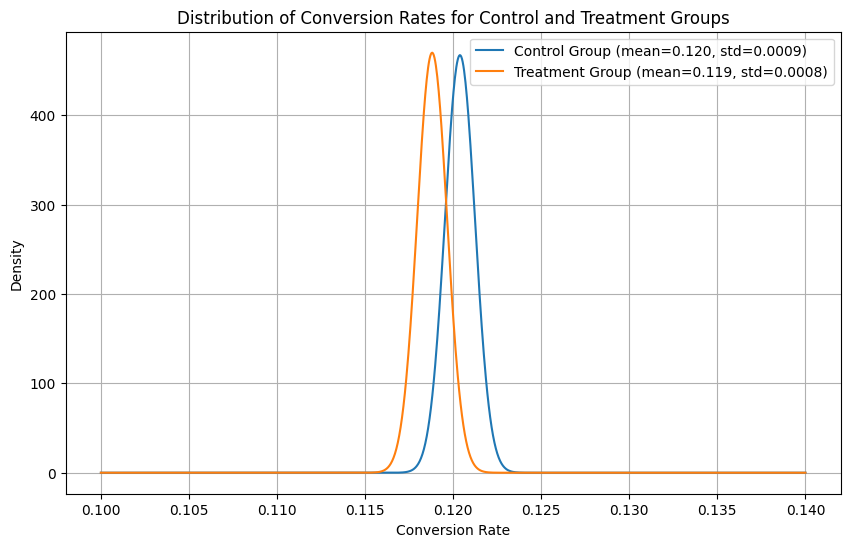

In [ ]:
# For a binomial distribution (like conversion), the mean is n*p and variance is n*p*(1-p)
# The sampling distribution of the proportion (p-hat) has mean p and variance p*(1-p)/n
# The standard deviation is sqrt(p*(1-p)/n)

# Control group parameters
n_control = len(cont_df)
p_control = conv_cont
std_control = np.sqrt(p_control * (1 - p_control) / n_control)

# Treatment group parameters
n_treatment = len(treat_df)
p_treatment = conv_treat
std_treatment = np.sqrt(p_treatment * (1 - p_treatment) / n_treatment)

# Generate points for the x-axis
x = np.linspace(0.10, 0.14, 1000) # Adjust the range based on your conversion rates

# Generate normal distribution curves
pdf_control = stats.norm.pdf(x, p_control, std_control)
pdf_treatment = stats.norm.pdf(x, p_treatment, std_treatment)

# Plot the distributions
plt.figure(figsize=(10, 6))
plt.plot(x, pdf_control, label=f'Control Group (mean={p_control:.3f}, std={std_control:.4f})')
plt.plot(x, pdf_treatment, label=f'Treatment Group (mean={p_treatment:.3f}, std={std_treatment:.4f})')

plt.title('Distribution of Conversion Rates for Control and Treatment Groups')
plt.xlabel('Conversion Rate')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

# Sample size for an A/B test
Calculate the required sample size for an A/B test given a baseline conversion rate, desired minimum detectable effect (MDE), significance level (alpha), and statistical power (beta).

## Define parameters

Determine the baseline conversion rate, desired minimum detectable effect (MDE), significance level (alpha), and statistical power (beta).

Here we are conducting a two sample z-test comparing the conversion rates of the control and treatment groups, the hypotheses would be:

H0: p_treatment ≤ p_control

H1: p_treatment > p_control

In [ ]:
baseline_conversion_rate = conv_cont
mde = 0.02
alpha = 0.05
beta = 0.20

print(f"Baseline Conversion Rate: {baseline_conversion_rate:.3f}")
print(f"Minimum Detectable Effect (MDE): {mde}")
print(f"Significance Level (alpha): {alpha}")
print(f"Beta (1-Power): {beta}")

Baseline Conversion Rate: 0.120
Minimum Detectable Effect (MDE): 0.02
Significance Level (alpha): 0.05
Beta (1-Power): 0.2


**Reasoning**:
Conversion data is binary (0 or 1) and follows a Bernoulli distribution, not a normal distribution. The normality assumption for the test applies to the sampling distribution of the difference in proportions, which is approximately normal with large sample sizes (as you have).

When dealing with proportions, the standard deviation is derived from the proportion itself and is estimated from the sample, which technically aligns more with the t-test framework.

Use the `tt_ind_ind` function from `statsmodels.stats.power` to calculate the required sample size per group for the A/B test, following the provided formulas for pooled probability and effect size.



In [ ]:
from statsmodels.stats.power import tt_ind_solve_power

p_pooled = (baseline_conversion_rate + baseline_conversion_rate + mde) / 2
effect_size = mde / np.sqrt(p_pooled * (1 - p_pooled))
required_sample_size = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=1 - beta, alternative='two-sided')

print(f"Required sample size per group: {int(np.ceil(required_sample_size))}")

Required sample size per group: 4451


In [ ]:
n_control = len(cont_df)
n_treatment = len(treat_df)

print(f"Number of observations in control group: {n_control}")
print(f"Number of observations in treatment group: {n_treatment}")
print(f"Required sample size per group: {int(np.ceil(required_sample_size))}")

if n_control >= required_sample_size and n_treatment >= required_sample_size:
    print("The current sample size in both groups is greater than or equal to the required sample size.")
else:
    print("The current sample size in at least one of the groups is less than the required sample size.")

Number of observations in control group: 145274
Number of observations in treatment group: 145311
Required sample size per group: 4451
The current sample size in both groups is greater than or equal to the required sample size.


In [ ]:
# t-test
from scipy.stats import ttest_ind
t_statistic, p_value = ttest_ind(cont_df['converted'], treat_df['converted'], equal_var=False, alternative='greater')
print(f"T-statistic: {t_statistic:.4f}")
print(f"P-value: {p_value:.4f}")



T-statistic: 1.3116
P-value: 0.0948


In [ ]:
s1 = cont_df['converted'].var(ddof=1)
s2 = treat_df['converted'].var(ddof=1)
n1, n2 = len(cont_df), len(treat_df)
se = np.sqrt(s1/n1 + s2/n2)

# dof
df = (s1/n1 + s2/n2)**2 / ((s1/n1)**2/(n1-1) + (s2/n2)**2/(n2-1))
alpha = 0.05
t_crit = t.ppf(1 - alpha, df)

diff = treat_df['converted'].mean() - cont_df['converted'].mean()

#one-sided CI
ci = (diff - t_crit*se, np.inf)
print(f"95% right-tailed CI: {ci}")


95% right-tailed CI: (np.float64(-0.0035593199935523906), inf)


This suggests there is not enough statistical evidence to conclude that the conversion rate in the treatment group is significantly greater than in the control group based on this test.

# Suggestions

*   Evaluate Cost/Benefit: Consider if the new page is still worth implementing based on factors other than conversion (e.g., development cost, long-term vision).
*   Increase MDE or sample size
*   Analyze Deeper: Look for effects on specific user segments or over time.
*   Iterate & Test: Refine the new page design based on insights and run new tests.
*   Explore Other Metrics: Analyze user behavior beyond conversion.
*   No Significant Gain: Accept that the new page didn't significantly improve conversion based on the test parameters.






